In [ ]:
from datasets import load_dataset
from torchvision.transforms import functional as F
from PIL import Image, ImageDraw
import random
import utils as ut
import torch

# Data pre-processing functions and loader

In [2]:
dataset = load_dataset("agucci/mri-sym2")

In the dataset 'train' contains the 1476 T1 images, and 'test' contains the 1674 T2 images

In [3]:
(len(dataset['train']), len(dataset['test']))

(1476, 1674)

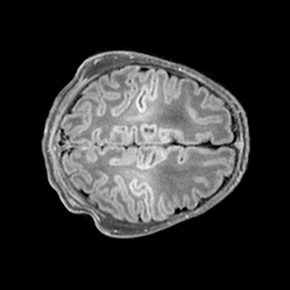

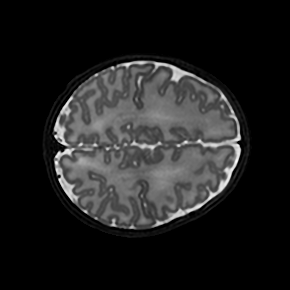

In [4]:
display(dataset['train'][10]['image'])
display(dataset['test'][10]['image'])

### Data transforms
To prepare for network training, some data pre-processing functions are available.  
These are illustrated in the following cells.  

In [5]:
example_image = dataset['train'][10]['image']
example_line = dataset['train'][10]['line']

example_image.size

(290, 290)

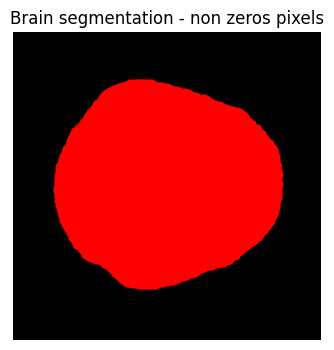

Number of Edge Points: 30647
Min coordinates: (40, 47)
Max coordinates: (251, 239)


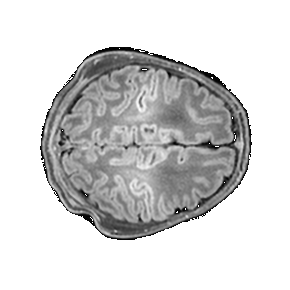

(49.06, 143.91) (243.12, 146.09)


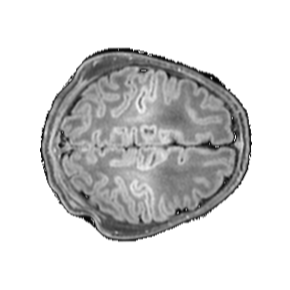

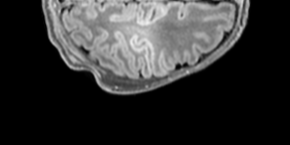

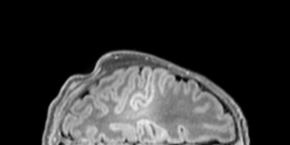

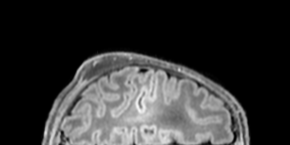

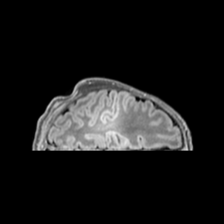

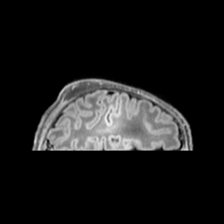

In [6]:
example_image = dataset['train'][10]['image']
example_line = dataset['train'][10]['line']


_, edge_points = ut.non_zeros(example_image, plot=True)                    # detect the skull edges, plot non_zeros in red
transparent_img = ut.segment(example_image, edge_points)               # extract the brain-only image part from background
display(transparent_img)

rotated_img = ut.rotate(transparent_img, example_line, show_line=False) # rotate the image so that the separation line is in the horizontal center 
display(rotated_img)

slice1, slice2 = ut.slice_aligned(rotated_img)                          # cut and extract the half hemispheres
display(slice1)
slice1 = slice1.rotate(180).transpose(Image.FLIP_LEFT_RIGHT)            # rotate 1 of the 2 for same orientation

display(slice1, slice2)

# center slices in black square (for resize without distortion)
square1, square2 = Image.new('L', (290, 290), 0), Image.new('L', (290, 290), 0) 
square1.paste(slice1, (0, 50)), square2.paste(slice2, (0, 50))
square1, square2 = square1.resize((224, 224)), square2.resize((224, 224))   # PIL resize
display(square1, square2)

#### Add noise
Simple example of how the noise will be added

In [7]:
def add_noise(image, size='big', noise_type='noisy', rgb=False, force_shape=0):
    """
    Add a random noise area to the upper or lower half of the image, close to the middle.

    Parameters:
    - image: PIL.Image object.
    - shape: Shape of the noise area ('circle', 'square', or 'polygon').
    - size: string indicating the size of the noise area ('big', 'mid', 'lil').

    Returns:
    - image with added noise area.
    """
    image = image.copy()
    draw = ImageDraw.Draw(image)
    shapes = ['circle', 'square']#, 'polygon']
    if force_shape == 0 or force_shape == 1:
        shape = shapes[force_shape]
    else:
        shape = shapes[random.randint(0, len(shapes) -1 )]

    #big 40x40 medium 20x20 small 10x10
    if size == 'big':
        x1, y1 = random.randint(66, 129), 105
        x2, y2 = x1+40, y1+40
    elif size == 'mid':
        x1, y1 = random.randint(66, 149), random.randint(106, 124)
        x2, y2 = x1+20, y1+20
    elif size == 'lil':
        x1, y1 = random.randint(66, 159), random.randint(106, 134)
        x2, y2 = x1+10, y1+10

    bbox = (x1, y1, x2, y2)

    if noise_type == 'plain':
        fill_color = 255        # Plain white
        if rgb: fill_color = (255, 255, 255)
    elif noise_type == 'noisy':
        # fill_color = 255
        if rgb: fill_color = tuple(random.randint(200, 215) for _ in range(3))  # Noisy white
        else: fill_color = random.randint(140, 215)

    # if bbox:
    if shape == 'circle':
        draw.ellipse(bbox, fill=fill_color)
    elif shape == 'square':
        draw.rectangle(bbox, fill=fill_color)
        # print('square')

    return image

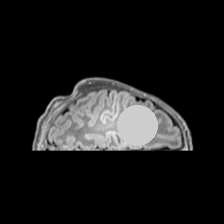

In [8]:
im_noise = ut.add_noise(square1, rgb=False)
im_noise

### PyTorch dataloader format
In the PyTorch training loop a custom data preparation is done, using huggingface dataset API for quicker transforms application to the whole dataset.

In [9]:
# MRI DATA
# dataset gets cached and won't need the whole processing in later runs
print("Loading data, might take a few minutes the first time")
# the function outputs a DatasetDict containing, train/valid/test datasets. 
# With the possibilty to output several distributions for k-fold training, while keeping a large test set of 20%
ds_folds = ut.siamese_noise_dataset_fold_range(n_splits=5, noise_size=6)
print("Data load completed")

Loading data, might take a few minutes the first time
Total dataset size: 3150
Number of T1 images: 1476
Number of T2 images: 1674
Data load completed


In [10]:
# example fold 1
ds_folds[0]

DatasetDict({
    train: Dataset({
        features: ['slice1', 'slice2', 'label', 'image_type'],
        num_rows: 2016
    })
    valid: Dataset({
        features: ['slice1', 'slice2', 'label', 'image_type'],
        num_rows: 504
    })
    test: Dataset({
        features: ['slice1', 'slice2', 'label', 'image_type'],
        num_rows: 630
    })
})

Then, the dataset is used as a torch DataLoader with [half1, half2, label] for each sample :

In [11]:
ds = ds_folds[0]
train_loader = torch.utils.data.DataLoader(ds['train'].with_format("torch"), batch_size=32)
val_loader = torch.utils.data.DataLoader(ds['valid'].with_format("torch"), batch_size=32)

In [12]:
print(next(iter(train_loader))['slice1'].shape) # should be [batch, 1, 224, 224]
print(next(iter(train_loader))['slice2'].shape) # should be [batch, 1, 224, 224]

next(iter(train_loader))['label'] # [32], [0-1] values

torch.Size([32, 1, 224, 224])
torch.Size([32, 1, 224, 224])


tensor([0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1,
        0, 0, 0, 0, 1, 1, 1, 1])

Visualize samples from Loader : 

pair label : 0


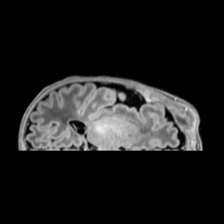

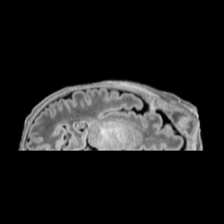

pair label : 1


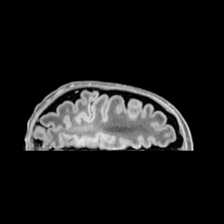

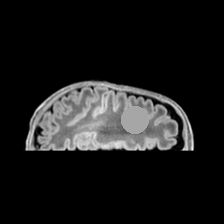

In [13]:
# plot first pairs from batch with lable 0 (no noise) and label 1 (noise)
items = next(iter(train_loader))
count0, count1 = 0, 0
while count0 < 1 and count1 < 1 : 
    for i in range(32):
        slice1 = items['slice1'][i]
        slice2 = items['slice2'][i]
        label = items['label'][i]
        if label.item() == 0 : 
            # print(slice1, slice2)
            if count0 ==0 :
                print(f"pair label : {label}")
                display(F.to_pil_image(slice1))
                display(F.to_pil_image(slice2))
            count0 += 1  
        else : 
            if count1 ==0 : 
                print(f"pair label : {label}")
                display(F.to_pil_image(slice1))
                display(F.to_pil_image(slice2))
            count1 += 1
